In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Loading the data from the files given
import pandas as pd
import json
path = "/content/gdrive/MyDrive/dblp-ref/dblp-ref-{}.json"
d = pd.DataFrame()
for i in range(4):
  temppath = path.format(i)
  out = []
  with open(temppath,'r') as file:
    file = file.readlines()
    for line in file:
      data = json.loads(line)
      out.append(data)
  df = pd.DataFrame(out)
  df = df.sample(5000, random_state=7081998)
  d = pd.concat([d, df], axis=0, ignore_index=True)
#print(data.head(), data.isnull().sum())
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   abstract    15262 non-null  object
 1   authors     20000 non-null  object
 2   n_citation  20000 non-null  int64 
 3   references  16479 non-null  object
 4   title       20000 non-null  object
 5   venue       20000 non-null  object
 6   year        20000 non-null  int64 
 7   id          20000 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.2+ MB


In [ ]:
#Creating a sample for manual analysis
sample_data = d.sample(3, random_state=5)

In [ ]:
sample_data.head()

,abstract,authors,n_citation,references,title,venue,year,id
14456,"For target tracking applications, wireless sen...","[Tolga Onel, Cem Ersoy, Hakan Delic]",50,"[24f63fb5-77e9-44ea-b9de-517dafcb5818, 2d7587c...",Information Content-Based Sensor Selection and...,IEEE Transactions on Mobile Computing,2009,c2362242-6301-42bd-a4e5-a482153b60b5
5536,The use of a group of femtocells to jointly pr...,"[Lester T. W. Ho, Imran Ashraf, Holger Claussen]",57,"[1024a0d1-212c-4fd4-b959-e6e0947cd682, 1e4c232...",Evolving femtocell coverage optimization algor...,"personal, indoor and mobile radio communications",2009,43bef234-1ed7-4b43-93f4-4d894ade839e
4029,Device-free localization (DFL) plays an import...,"[Ju Wang, Xiaojiang Chen, Dingyi Fang, Chase Q...",0,"[062177c2-423d-492d-9a3e-73a7d552eb86, 30315e4...",Poster abstract: Implications of target divers...,information processing in sensor networks,2014,0fe9270c-fe6c-4727-bc58-ccfeed9c58a5


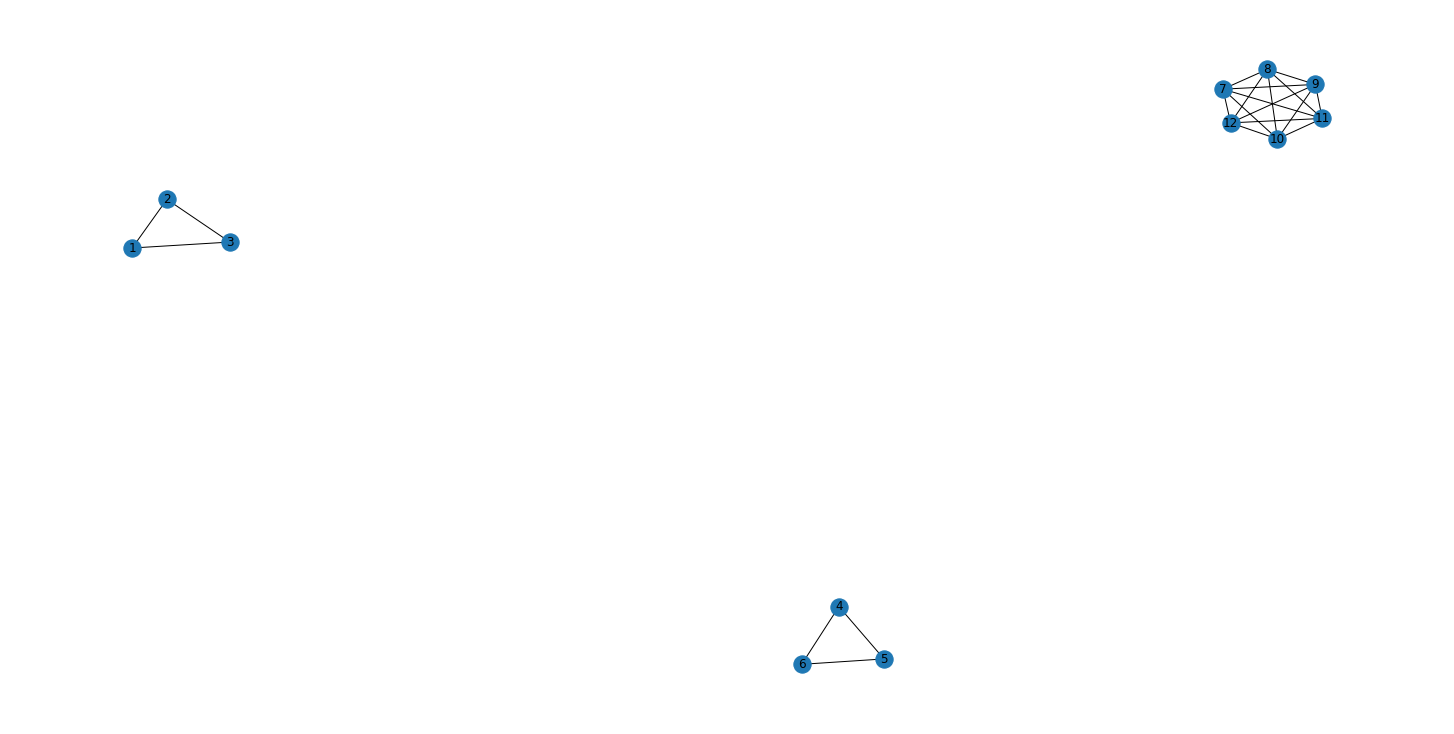

In [ ]:
#Sample Undirected Graph for Known Author
import networkx as nx
import matplotlib.pyplot as plt

g = nx.Graph()
id_labels = {}
name_labels = {}
label = 1
file1 = open(r"/content/gdrive/MyDrive/graph1.txt",'w+')
for author in sample_data['authors']:
  for auth in author:
    g.add_node(auth)
    name_labels[auth] = label
    id_labels[label] = author
    label += 1
  if len(author)==1:
    file1.write(f'{name_labels[author[0]]},0\n')
  for i in range(len(author)):
    for j in range(i+1,len(author)):
       file1.write(f'{name_labels[author[i]]},{name_labels[author[j]]}\n')
       g.add_edge(author[i],author[j])

#plt.figure(figsize=(20,10))
#nx.draw(g, with_labels = True)
gh= nx.relabel_nodes(g, name_labels)
plt.figure(figsize=(20,10))
nx.draw(gh, with_labels=True)
file1.close()

In [ ]:
import itertools
def maximal(g):
  if (len(g.nodes()) == 1):
      return g.nodes()[0]
  highest = list(nx.find_cliques(g))
  #print(highest)
  highest.sort(key=len)
  #print(highest)
  length = highest[-1]
  #print(length)
  new = []
  for auth in highest:
    if len(auth) == len(length):
      new.append(auth)
  return str(new)[1:-1]
  #return cliques[-1]
print(maximal(g))
def find_cliques_size_k(G, k):
  count = 0
  for clique in nx.find_cliques(G):
      if len(clique) == k:
          count += 1
      elif len(clique) > k:
          count += len(list(itertools.combinations(clique, k)))
  return count
for i in range(3,6):
  print(i,find_cliques_size_k(g,i))
#print(sorted(g.degrees())[-1])

['Dingyi Fang', 'Weike Nie', 'Xiaojiang Chen', 'Chase Q. Wu', 'Tianzhang Xing', 'Ju Wang']
3 22
4 15
5 6


In [ ]:
sample_data.dropna(subset=['references'],inplace=True)

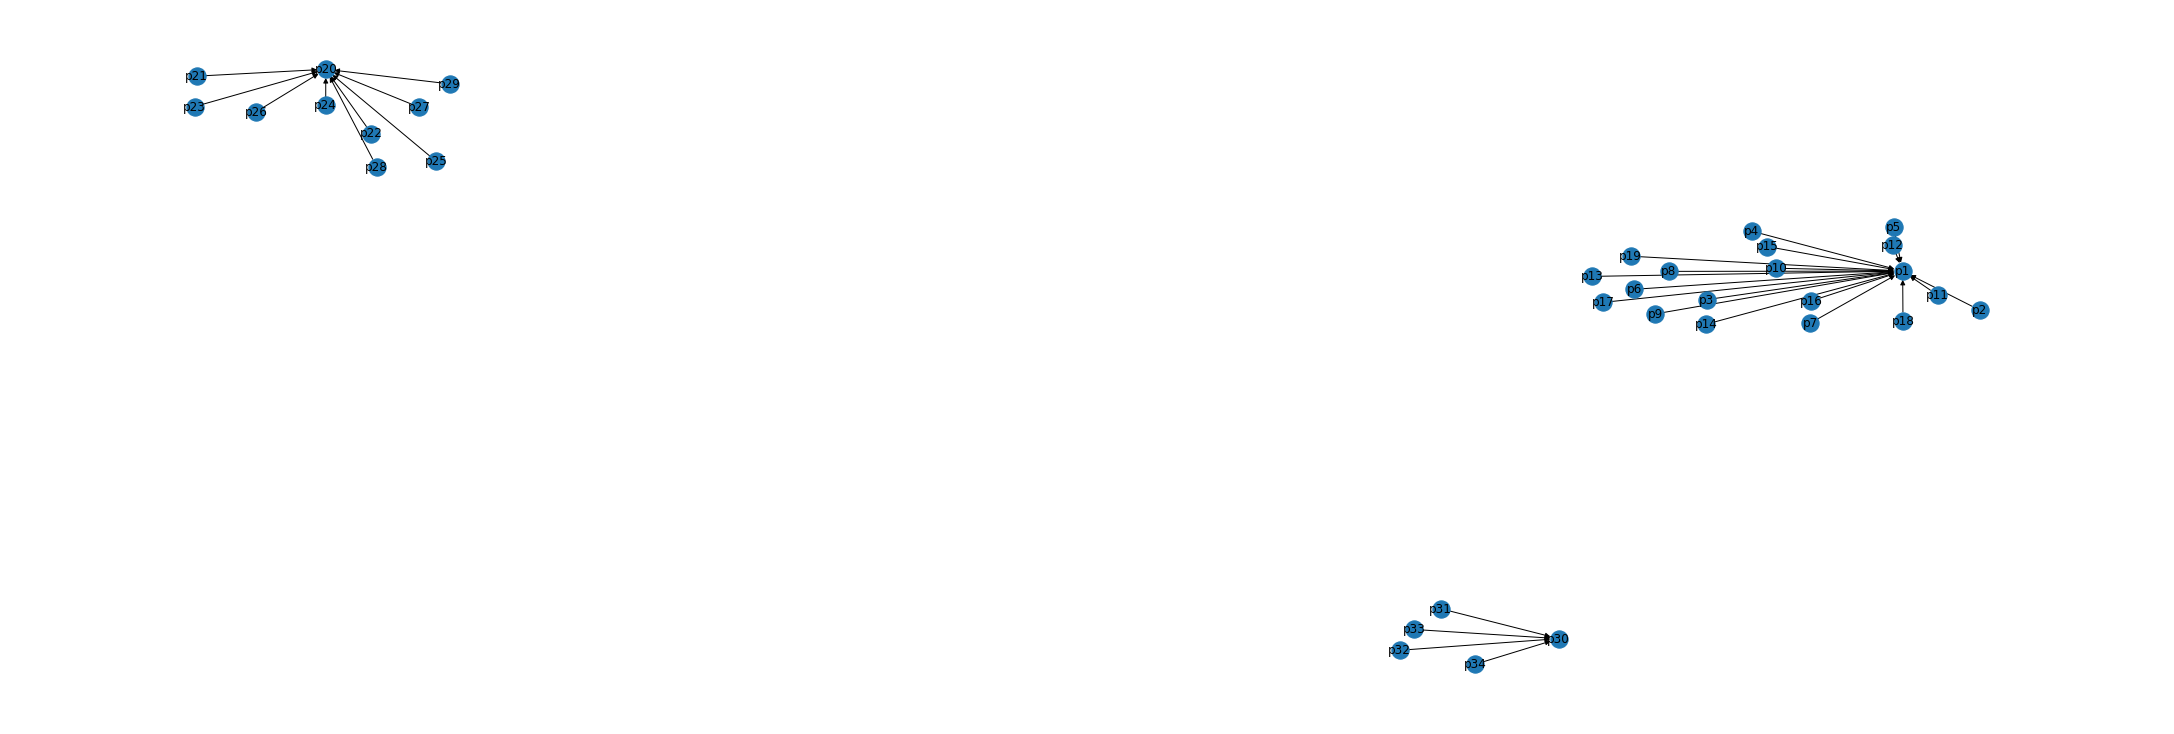

In [ ]:
#Sample for Paper citation graph
x = nx.DiGraph()
paper_labels = {}
key = 1
file2 = open(r"/content/gdrive/MyDrive/graph2.txt",'w+')
for i in range(len(sample_data)):
  references = sample_data.iloc[i]['references']
  id = sample_data.iloc[i]['id']
  if id not in paper_labels:
    paper_labels[id] = 'p' + str(key)
    key = key+1
  id = paper_labels[id]
  if len(references) == 0:
    x.add_node(id)
    id = id[1:] if 'p' in id else id
    file2.write(f'0,{id}\n')
    continue
  for ref in references:
    if ref not in paper_labels:
      paper_labels[ref] = 'p' + str(key)
      key = key + 1
    file2.write(f'{paper_labels[ref][1:]},{id[1:]}\n')
    x.add_edge(paper_labels[ref],id)
plt.figure(figsize=(30,10))
nx.draw(x, with_labels=True)
file2.close()

In [ ]:
#Top papers for sample
def top(x):
  d=nx.in_degree_centrality(x)
  paper = []
  for i in range(10):
    paper.append(max(d, key=d.get))
    del d[max(d, key=d.get)]
  return paper
temp = {i:j for j,i in paper_labels.items()}
for i in top(x):
  print(temp[i],i)

c2362242-6301-42bd-a4e5-a482153b60b5 p1
43bef234-1ed7-4b43-93f4-4d894ade839e p20
0fe9270c-fe6c-4727-bc58-ccfeed9c58a5 p30
24f63fb5-77e9-44ea-b9de-517dafcb5818 p2
2d7587c4-4af6-44a4-b0ec-9d83b8b85322 p3
4667b514-e6d6-484b-b8fb-886715bf9e43 p4
573c7c16-e33b-4485-a857-f547379e5120 p5
628baa3a-ed23-4bcf-92af-078d2a0a2317 p6
68a1122c-9f8e-4135-a571-f4c8a712134c p7
6cb4bbce-7dcb-4915-89fb-36203b60c745 p8


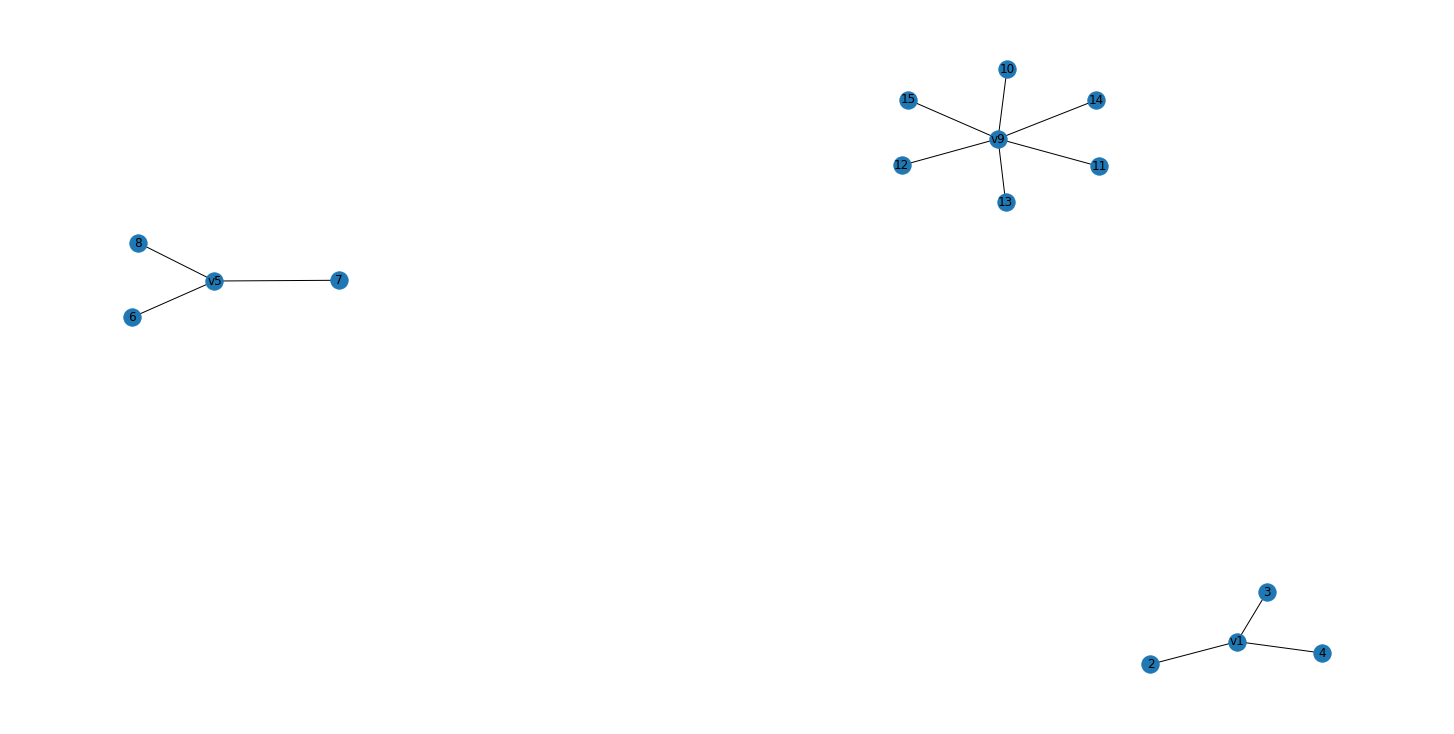

In [ ]:
#Sample graph for Author venue
g = nx.Graph()
Venue_labels = {}
Author_labels = {}
key = 1
label = 1
file3 = open(r"/content/gdrive/MyDrive/graph3.txt",'w+')
for i in range(len(sample_data)):
  ven = sample_data.iloc[i]['venue']
  authors = sample_data.iloc[i]['authors']
  if ven not in paper_labels:
    Venue_labels[ven] = 'v' + str(key)
    key = key+1
  ven = Venue_labels[ven]
  for auth in authors:
    if auth not in Author_labels:
      Author_labels[auth] = key
      key = key + 1
    g.add_edge(ven,auth)
    file3.write(f'{ven[1:]},{Author_labels[auth]}\n')
#nx.draw(g, with_labels = True)
gh= nx.relabel_nodes(g, Author_labels)
plt.figure(figsize=(20,10))
nx.draw(gh, with_labels=True)
file3.close()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.Graph()
id_labels = {}
name_labels = {}
label = 1
file1 = open(r"/content/gdrive/MyDrive/real_graph1.txt",'w+')
for author in d['authors']:
  for auth in author:
    g.add_node(auth)
    name_labels[auth] = label
    id_labels[label] = author
    label += 1
  for i in range(len(author)):
    for j in range(i+1,len(author)):
       file1.write(f'{name_labels[author[i]]},{name_labels[author[j]]}\n')
       g.add_edge(author[i],author[j])

#plt.figure(figsize=(20,10))
#nx.draw(g, with_labels = True)
gh= nx.relabel_nodes(g, name_labels)
plt.figure(figsize=(20,10))
#nx.draw(gh, with_labels=True)
file1.close()

<Figure size 1440x720 with 0 Axes>

In [ ]:
import itertools
def maximal(g):
  if (len(g.nodes()) == 1):
      return g.nodes()[0]
  highest = list(nx.find_cliques(g))
  #print(highest)
  highest.sort(key=len)
  #print(highest)
  length = highest[-1]
  #print(length)
  new = []
  for auth in highest:
    if len(auth) == len(length):
      new.append(auth)
  return str(new)[1:-1]
  #return cliques[-1]
print(maximal(g))
def find_cliques_size_k(G, k):
  count = 0
  for clique in nx.find_cliques(G):
      if len(clique) == k:
          count += 1
      elif len(clique) > k:
          count += len(list(itertools.combinations(clique, k)))
  return count
for i in range(3,6):
  print(i,find_cliques_size_k(g,i))
#print(sorted(g.degrees())[-1])

['George Stamoulis', 'Andreas Ikonomopoulos', 'Maria-Esther Vidal', 'Hajira Jabeen', 'Emanuele Angiuli', 'Sergio Albani', 'Michele Lazzarini', 'Giorgos Argyriou', 'Efstathios Grigoropoulos', 'Gezim Sejdiu', 'Nikiforos Pittaras', 'Aad Versteden', 'Sören Auer', 'Vangelis Karkaletsis', 'Paulo Nunes', 'Angelos Charalambidis', 'Axel-Cyrille Ngonga Ngomo', 'Athanasios Davettas', 'Ivan Ermilov', 'Charalambos Pappas', 'Manolis Koubarakis', 'George Papadakis', 'Pythagoras Karampiperis', 'Spyros Andronopoulos', 'Ronny Siebes', 'Mohamed Mami', 'Erika Pauwels', 'Victor de Boer', 'Stasinos Konstantopoulos', 'Jens Lehmann', 'Simon Scerri', 'George Giannakopoulos', 'Iraklis A. Klampanos', 'Mandy Vlachogiannis']
3 141981
4 288395
5 847707


In [ ]:
from numpy import NaN
x = nx.DiGraph()
paper_labels = {}
key = 1
file2 = open(r"/content/gdrive/MyDrive/real_graph2.txt",'w+')
for i in range(len(d)):
  references = d.iloc[i]['references']
  id = d.iloc[i]['id']
  if id not in paper_labels:
    paper_labels[id] = 'p' + str(key)
    key = key+1
  id = paper_labels[id]
  if references is NaN:
    x.add_node(id)
    id = id[1:] if 'p' in id else id
    file2.write(f'0,{id}\n')
    continue
  for ref in references:
    if ref not in paper_labels:
      paper_labels[ref] = 'p' + str(key)
      key = key + 1
    file2.write(f'{paper_labels[ref][1:]},{id[1:]}\n')
    x.add_edge(paper_labels[ref],id)
plt.figure(figsize=(30,10))
#nx.draw(x, with_labels=True)
file2.close()

<Figure size 2160x720 with 0 Axes>

In [ ]:
def top(x):
  d=nx.in_degree_centrality(x)
  #print(d)
  paper = []
  for i in range(10):
    paper.append(max(d, key=d.get))
    del d[max(d, key=d.get)]
  return paper
temp = {i:j for j,i in paper_labels.items()}
for i in top(x):
  print(temp[i], i)

d7e26bd5-1b0b-4f4c-8255-9f3b03154713 p111646
853ce2eb-8835-4ebe-b0a1-a016d78e387f p121962
3bfce660-26cf-47a5-80c7-38499fb51e00 p105871
66b847fc-cfeb-40c7-bf53-90089bc78877 p128358
bb5f7fb3-3e45-4933-80fa-73b3eda6d8cc p87108
cf34964e-550c-4e77-9c17-5220ae2e74be p117762
c162bab7-6c68-4f11-8f65-c658af7223da p66189
071660fb-330e-4ac8-999e-8cbc7f03ee0c p134292
ccdff6b8-0ce1-4210-acac-886712dbe543 p120566
8e42572a-c5a6-405d-8e57-23809d4720c3 p54840


In [ ]:
g = nx.Graph()
Venue_labels = {}
Author_labels = {}
key = 1
label = 1
file3 = open(r"/content/gdrive/MyDrive/real_graph3.txt",'w+')
for i in range(len(d)):
  ven = d.iloc[i]['venue']
  authors = d.iloc[i]['authors']
  if ven not in paper_labels:
    Venue_labels[ven] = 'v' + str(key)
    key = key+1
  ven = Venue_labels[ven]
  for auth in authors:
    if auth not in Author_labels:
      Author_labels[auth] = key
      key = key + 1
    g.add_edge(ven,auth)
    file3.write(f'{ven[1:]},{Author_labels[auth]}\n')
#nx.draw(g, with_labels = True)
gh= nx.relabel_nodes(g, Author_labels)
plt.figure(figsize=(20,10))
#nx.draw(gh, with_labels=True)
file3.close()

<Figure size 1440x720 with 0 Axes>